In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Sequence
from sigmf import SigMFFile, sigmffile
from sigmf.utils import get_data_type_str
from datetime import datetime, timezone
import os
from enum import Enum
from string_to_binary_coder import encode_string
from TurboCoder import TurboCoder

In [23]:
def generate_m_sequence(length=16):
    """
    Generiert eine 16 Bit lange M-Sequenz mit LFSR (Linear Feedback Shift Register) als BPSK Sequenz.
    Verwendetes primitives Polynom: x^4 + x^3 + 1 (Taps an Position 3 und 4)
    """
    register = [1, 1, 1, 1]  # Initialzustand (darf nicht alle 0 sein)
    sequence = []

    for _ in range(length):
        # Feedback-Berechnung (XOR der Taps)
        feedback = register[3] ^ register[2]  # 0-indizierte Positionen
        sequence.append(register.pop())
        register.insert(0, feedback)

    return 2*np.asarray(sequence)-1

def zadoff_chu_sequence(length, root=25):
    """
    Generiert zu gegebener Länge und Wurzel eine ZC-Sequenz (QPSK).
    :param length:
    :param root:
    :return:
    """
    n = np.arange(0, length)
    if length % 2 != 0:
        return np.exp(1j * np.pi * root * n * (n + 1) / length)
    return np.exp(1j * np.pi * root * n**2 / length)


def normalize_energy(signal):
    energy = np.sum(np.abs(signal) ** 2)
    return signal / np.sqrt(energy)

def dirac_impulse(t, tau, amplitude=1.0, width=1e-9):
    """
    Erzeugt eine Annäherung an einen Dirac-Impuls.

    :param t: Zeitvektor (numpy array)
    :param tau: Verschiebung des Impulses in Sekunden
    :param amplitude: Amplitude des Impulses (Standard: 1.0)
    :param width: Breite des Impulses in Sekunden (Standard: 1e-9)
    :return: numpy array mit dem Dirac-Impuls
    """
    # Berechne die Zeitauflösung
    dt = t[1] - t[0]

    # Initialisiere das Ausgabe-Array mit Nullen
    dirac = np.zeros_like(t)

    # Finde den Index, der tau am nächsten ist
    idx = np.argmin(np.abs(t - tau))

    # Setze den Impuls
    if width <= dt:
        # Wenn die gewünschte Breite kleiner als die Zeitauflösung ist,
        # setze einfach einen einzelnen Punkt
        dirac[idx] = 1
    else:
        # Andernfalls erstelle einen schmalen Rechteckimpuls
        half_width = int(width / (2 * dt))
        start = max(0, idx - half_width)
        end = min(len(t), idx + half_width + 1)
        dirac[start:end] = 1

    return dirac

def qpsk_modulation(data_bits):
    # Ensure the number of bits is even
    if len(data_bits) % 2 != 0:
        data_bits = np.append(data_bits, 0)  # Pad with 0 if odd

    # Reshape the bits into pairs
    bit_pairs = data_bits.reshape(-1, 2)

    # Map bit pairs to QPSK symbols: Gray Coding
    modulation_data_symbols = np.zeros(len(bit_pairs), dtype=complex)
    modulation_data_symbols[np.all(bit_pairs == [0, 0], axis=1)] = (1 + 1j) / np.sqrt(2)
    modulation_data_symbols[np.all(bit_pairs == [0, 1], axis=1)] = (-1 + 1j) / np.sqrt(2)
    modulation_data_symbols[np.all(bit_pairs == [1, 1], axis=1)] = (-1 - 1j) / np.sqrt(2)
    modulation_data_symbols[np.all(bit_pairs == [1, 0], axis=1)] = (1 - 1j) / np.sqrt(2)

    return modulation_data_symbols

def bpsk_modulation(data_bits):
    return 2 * data_bits - 1

class BasebandPulseForm(Enum):
    RECT = "rect"
    RAISED_COSINE = "raised_cosine"

def add_pilots(modulation_data_symbols, params):
    """
    Adds pilot symbols to the modulation data symbols at specified intervals.

    :param modulation_data_symbols: Array of modulation data symbols
    :param params: Dictionary containing 'pilot_sym', 'pilot_start_idx', and 'pilot_repetition'
    :return: Array of modulation data symbols with pilots
    """

    total_symbols = params['frame']['data_syms']
    pilot_symbol = params['frame']['pilot_sym']
    pilot_start_idx = params['frame']['pilot_start_idx']
    pilot_repetition = params['frame']['pilot_repetition']

    # Berechnung der Anzahl der Piloten

    modulation_data_symbols_with_pilots = np.zeros(params['frame']['data_syms'], dtype=np.complex64)


    pilot_idx = np.arange(pilot_start_idx, total_symbols, pilot_repetition + 1)
    num_pilots = pilot_idx.size

    data_sym_idx = 0

    for i in range(len(modulation_data_symbols_with_pilots)):
        if np.isin(i, pilot_idx):
            modulation_data_symbols_with_pilots[i] = pilot_symbol
        elif data_sym_idx < modulation_data_symbols.size:
            modulation_data_symbols_with_pilots[i] = modulation_data_symbols[data_sym_idx]
            data_sym_idx += 1
        else:
            modulation_data_symbols_with_pilots[i] = 0
    return modulation_data_symbols_with_pilots

def get_raised_cosine_pulse(num_taps=101, roll_off=0.35, samples_per_symbol=8):
    Ts = samples_per_symbol
    t = np.arange(num_taps) - (num_taps-1)//2
    h = np.sinc(t/Ts) * np.cos(np.pi*roll_off*t/Ts) / (1 - (2*roll_off*t/Ts)**2)
    return h

def get_rect_pulse(num_taps=101, samples_per_symbol=8):
    h = np.zeros(num_taps)
    h[num_taps//2-samples_per_symbol//2:num_taps//2+samples_per_symbol//2] = 1
    return h

def plot_iq_samples(x=None, x_i=None, x_q=None, sps=None, marked_symbol=5):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    if sps is None:
        index = marked_symbol - 1
    else:
        index = (marked_symbol - 1) * sps

    if (x_i is None) and (x_q is None) and (x is not None):
        x_i = np.real(x)
        x_q = np.imag(x)

    data = [x_i, x_q]
    titles = [r"Realteil: $ x_{\rm{I}}[n] $", r"Imaginärteil: $ x_{\rm{Q}}[n]$"]
    ylabels = [r'$x_{\rm{I}}[n]$', r'$x_{\rm{Q}}[n]$']

    for i, ax in enumerate(axes[:2]):
        ax.stem(data[i])
        ax.grid(True)
        ax.set_xlabel(r'$n$')
        ax.set_ylabel(ylabels[i])
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_title(titles[i])
        ax.plot(index, data[i][index], 'o', color='orange')

    # Scatter plot
    if sps is None:
        axes[2].scatter(x_i[::sps], x_q[::sps])
    else:
        axes[2].scatter(x_i, x_q)
    axes[2].plot(x_i[index], x_q[index], 'o', color='orange')
    axes[2].set_aspect('equal', adjustable='box')
    axes[2].grid(True)

    # Draw unit circle
    unit_circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    axes[2].add_artist(unit_circle)

    # Set titles and labels
    axes[2].set_title('IQ-Plot')
    axes[2].set_xlabel(r'$\Im$')
    axes[2].set_ylabel(r'$\Re$')

    plt.tight_layout()
    return fig, axes

def add_awgn_noise(signal, snr_dB):
    """
    Adds AWGN noise to the signal based on the specified SNR in dB.
    :param signal: Input signal
    :param snr_dB: Signal-to-Noise Ratio in dB
    :return: Signal with added AWGN noise
    """
    signal_power = np.mean(np.abs(signal) ** 2)
    snr_linear = 10 ** (snr_dB / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise.real

def add_channel(t: Union[Sequence[float], np.ndarray],
                signal: Union[Sequence[float], np.ndarray],
                paths_m: Union[Sequence[float], np.ndarray],
                fc: float) -> np.ndarray:
    dirac_sum = np.zeros_like(signal)
    c0 = 3e8 # m/s speed of light
    for d_m in paths_m:
        amplitude = np.sqrt(c0/(4*np.pi*d_m*fc))
        tau = d_m / c0
        dirac_sum += amplitude * dirac_impulse(t, tau)
    return np.fft.ifft(np.fft.fft(s_hf)*np.fft.fft(dirac_sum)).real

def plot_passband_signals(t, x_i_shaped, x_q_shaped, s_c_I, s_c_Q, s_hf):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

    # Plot I(t) * s_c,I(t)
    ax1.plot(t, x_i_shaped * s_c_I, label=r"$x_{\rm{I, shaped}}(t) $ $ s_{\rm{c,I}}(t)$")
    ax1.plot(t, x_i_shaped, color='red', label=r"$x_{\rm{I, shaped}}(t) $")
    ax1.set_title(r"Passbandsignal: $x_{\rm{I, shaped}}(t) $ $ s_{\rm{c,I}}(t)$")
    ax1.set_ylabel(r"$x_{\rm{I, shaped}}(t) s_{\rm{c,I}}(t)$")
    ax1.set_xlabel(r"$t$ [s]")
    ax1.legend()
    ax1.grid(True)

    # Plot Q(t) * s_c,Q(t)
    ax2.plot(t, x_q_shaped * s_c_Q, label=r"$x_{\rm{Q, shaped}}(t) $ $ s_{\rm{c,Q}}(t)$")
    ax2.plot(t, x_q_shaped, color='red', label=r"$x_{\rm{Q, shaped}}(t) $")
    ax2.set_title(r"Passbandsignal: $x_{\rm{Q, shaped}}(t) $ $ s_{\rm{c,Q}}(t)$")
    ax2.set_ylabel(r"$x_{\rm{Q, shaped}}(t) s_{\rm{c,Q}}(t)$")
    ax2.set_xlabel(r"$t$ [s]")
    ax2.legend()
    ax2.grid(True)

    # Plot s_HF(t)
    ax3.plot(t, s_hf)
    ax3.set_title(r"Passbandsignal: $s_{\rm{HF}}(t)$")
    ax3.set_ylabel(r"$s_{\rm{HF}}(t)$")
    ax3.set_xlabel(r"$t$ [s]")
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

def add_cfo(iq_chunk, cfo, fs):
    """
    Adds a frequency offset to the IQ chunk.
    :param iq_chunk:
    :param cfo: in Hz
    :return:
    """
    cfo_signal = np.exp(1j * (2 * np.pi * cfo / fs * np.arange(iq_chunk.size)))
    iq_chunk_with_fo = iq_chunk * cfo_signal
    return iq_chunk_with_fo

# Parameter für Signalverarbeitung

In [4]:
params = {
    # Basisband Puls soll eine Dauer T_s von 0.5 Sekunden haben
    "T_s": 1/2, # in seconds
    # Der Puls soll 16 Samples lang sein
    "sps": 16, # in samples
    # num_tabs gibt die Gesamtlänge des Basisbandpulses an, muss natürlich länger sein als die Länge des Pulses sps. sps=101 wäre eine gute Zahl.
    "num_taps": 101,
    # pulseform gibt die Basisbandpulse-Form an, welche Sie verwenden möchten
    "pulseform": BasebandPulseForm.RAISED_COSINE,  # Verwendung des oben definierten Enums BasebandPulseForm
    "roll_off": 0.35,  # der Roll-Off Faktor falls BasebandPulseForm.RAISED_COSINE verwendet werden soll, anderenfalls bleibt der Parameter ungenutzt
    "frame": {
        "sync_syms": 16,
        "data_syms": 64,
        "pilot_sym": np.sqrt(1+1j), #1, #
        "pilot_start_idx": 2,
        "pilot_repetition": 5, # after every fifth sym
    }
}

# Nun noch die Dauer eines Samples
params['T_sample'] = params['T_s'] / params['sps'] # T_sample = T_s / sps

# String to bits

In [5]:
information_str = "HTWK"
information_bits = encode_string(information_str)
print(information_bits)
print(len(information_bits[0]))

[[0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1]]
32


# Kanalcodierung

In [6]:
turbo_coder = TurboCoder(code_rate=1/2, constraint_length=4)
encoded_bits = turbo_coder.encode(information_bits)
print(encoded_bits)
print (len(encoded_bits))

[0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0
 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1]
72


### Mapping der Bits $\vec{b}[m]$ auf Modulationssymbole & Erstellung eines Frames

<div style="text-align: center;">
    <img src="./data/images/DataFrame.png" alt="IQ Sampling Receiver" width="600"/>
</div>

In [7]:
modulation_data_symbols = qpsk_modulation(encoded_bits)

In [8]:
modulation_data_symbols_with_pilots = add_pilots(modulation_data_symbols, params)
print(modulation_data_symbols_with_pilots)
print(modulation_data_symbols_with_pilots.size)

[ 0.70710678+0.70710678j  0.70710678-0.70710678j  1.09868411+0.45508986j
 -0.70710678+0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j  0.70710678+0.70710678j  1.09868411+0.45508986j
  0.70710678-0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j  1.09868411+0.45508986j
  0.70710678+0.70710678j -0.70710678+0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  1.09868411+0.45508986j
 -0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678+0.70710678j  0.70710678+0.70710678j  1.09868411+0.45508986j
 -0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  1.09868411+0.45508986j
  0.70710678+0.70710678j  0.70710678-0.70710678j -0.70710678-0.70710678j
  0.70710678-0.70710678j  0.70710678-0.70710678j  1.09868411+0.45508986j
  0.70710678-0.70710678j  0.70710678-0.70710678j -0

In [9]:
synchronization_sequence = zadoff_chu_sequence(params['frame']['sync_syms'], root=25)

In [10]:
symbols = np.concatenate((synchronization_sequence, modulation_data_symbols_with_pilots))

# Pulse Shaping

In [11]:
h_pulse_form = get_rect_pulse(num_taps=params['num_taps'], samples_per_symbol=params['sps']) \
                if params['pulseform'] is BasebandPulseForm.RECT else get_raised_cosine_pulse(num_taps=params['num_taps'], samples_per_symbol=params['sps'], roll_off=params['roll_off'])

In [12]:
x_i_no_shape = np.zeros(len(symbols) * params['sps'])
x_q_no_shape = np.zeros(len(symbols) * params['sps'])

t = np.arange(len(x_i_no_shape)) * params['T_sample']
for m in range(len(symbols)):
    x_i_no_shape += symbols[m].real * dirac_impulse(t=t, tau = m * params['T_s'])
    x_q_no_shape += symbols[m].imag * dirac_impulse(t=t, tau = m * params['T_s'])

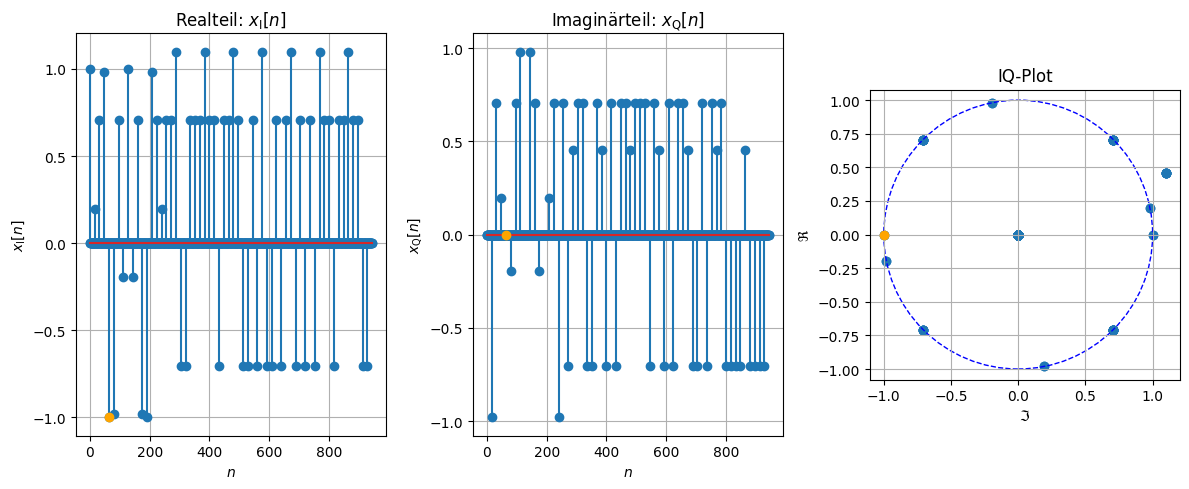

In [13]:
fig, axes = plot_iq_samples(x_i=x_i_no_shape, x_q=x_q_no_shape, sps=params['sps'])
plt.show()

In [14]:
x_i_shaped = np.convolve(x_i_no_shape, h_pulse_form)
x_q_shaped = np.convolve(x_q_no_shape, h_pulse_form)

In [15]:
t = np.arange(x_i_shaped.size) * params['T_sample']


s_c_I = np.cos(2*np.pi*params['fc']*t)
s_c_Q = np.cos(2*np.pi*params['fc']*t + np.pi/2)

In [16]:
s_hf = x_i_shaped * s_c_I + x_q_shaped * s_c_Q
#plot_passband_signals(t, x_i_shaped, x_q_shaped, s_c_I, s_c_Q, s_hf)

# AWGN Kanal, Mehrwegeausbreitung & CFO

In [17]:
tau = 0.125/2 + 1/params['fc']
c0 = 3e8
paths = np.array([tau*c0,]) #d = tau * c0
t = np.arange(s_hf.size) * params['T_sample']
s_hf = add_channel(t=t, signal=s_hf, paths_m=paths, fc=params['fc'])
rx_samples = add_awgn_noise(s_hf, 12)
cfo = params['sps'] * 1e-2
rx_samples = add_cfo(iq_chunk=rx_samples, cfo=cfo, fs=params['sps'])

# Speichern als SigMF

In [18]:
filepath = "data/measurements"
if not os.path.exists(filepath):
    os.makedirs(filepath)
date = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
filename = f"measurement_{int(params['fc'])}Hz_{date}"


## *.data

In [19]:
s_hf.tofile(f"{filepath}/{filename}.sigmf-data")

## *.meta

In [20]:
meta = SigMFFile(
    global_info= {
        SigMFFile.DATATYPE_KEY: get_data_type_str(rx_samples),
        SigMFFile.VERSION_KEY: "0.0.1",
        SigMFFile.SAMPLE_RATE_KEY: params['sps'],
        SigMFFile.DESCRIPTION_KEY: "Example SigMF file",
        SigMFFile.AUTHOR_KEY: "John Doe",
    }
)

meta.add_capture(0, metadata={
    SigMFFile.FREQUENCY_KEY: params['fc'],
    SigMFFile.DATETIME_KEY: datetime.now(timezone.utc).isoformat()+"Z",
    #"core:samp_rate_error": samp_err_rate,
    "core:cfo": cfo,
})

meta.tofile(f"{filepath}/{filename}.sigmf-meta")

# Einlesen des SigMF Files

In [21]:
data_as_ndarray = sigmffile.fromfile(f"{filepath}/{filename}.sigmf").read_samples()
print(data_as_ndarray[10:20])

[-4.7641755e-17+0.00066392j  3.4029824e-18-0.00222252j
 -5.6496016e-03-0.00936488j -1.2131926e-02-0.01279737j
 -1.0725939e-02-0.00610715j -5.4447718e-17+0.00593788j
  9.9782944e-03+0.01094538j  8.2023237e-03+0.00356747j
  6.8059647e-18-0.00036141j  3.6227542e-03+0.01150203j]


## Bsp.: Lesen der Metadaten

In [22]:
cfo = float(sigmffile.fromfile(f"{filepath}/{filename}.sigmf").get_capture_info(0).get("core:cfo",0))
cfo

0.16